# 1. 선형회귀

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

In [107]:
df_raw = pd.read_csv("3. Big Data 분석/체질검사.csv", engine="python")

df_raw.head()

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST  
0    45.0     29.0   21.4  
1    29.0     30.0   18.8  
2    30.8     25.7   18.8  
3    31.7     27.3   16.9  
4    34.7     29.1   18.4

## 목표 변수 FAT을 예측하기 위해서 가장 연관된 변수를 찾아야 한다.
## WEIGHT, HEIGHT, ABDOMEN이 FAT과 연관되어 있다고 생각했다.

### 먼저 몸무게와 키를 각각 kg, cm로 변환해준다.

In [108]:
df_raw["WEIGHT"] = df_raw["WEIGHT"] * 0.45
df_raw["HEIGHT"] = df_raw["HEIGHT"] * 2.54
df_raw.head()

FAT  AGE    WEIGHT   HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  \
0  35.2   46  163.4175  183.515  51.2  136.2    148.1  147.7   87.3  49.1   
1  11.8   27   75.6000  180.975  38.1   93.0     79.1   94.5   57.3  36.2   
2  22.2   69   79.9875  173.990  38.7  102.0     95.0   98.3   55.0  38.3   
3  10.6   57   66.4875  167.005  35.2   99.6     86.4   90.1   53.0  35.0   
4  47.5   51   98.5500  162.560  41.2  119.8    122.1  112.8   62.5  36.9   

   ANKLE  BICEPS  FOREARM  WRIST  
0   29.6    45.0     29.0   21.4  
1   24.5    29.0     30.0   18.8  
2   21.8    30.8     25.7   18.8  
3   21.3    31.7     27.3   16.9  
4   23.6    34.7     29.1   18.4

In [109]:
df_raw["BMI"] = (df_raw["WEIGHT"] / (df_raw["HEIGHT"] * df_raw["HEIGHT"]) * 10000)
df_raw["BMI"].head()

0    48.523870
1    23.082595
2    26.422478
3    23.838617
4    37.293165
Name: BMI, dtype: float64

## BMI 라는 파생 변수를 생성하여 키, 몸무게를 종합적으로 고려하여 FAT을 예측할 수 있도록 한다.

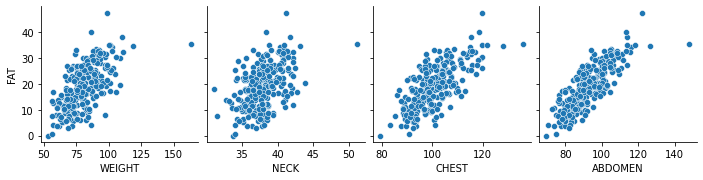

In [113]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT", "NECK", "CHEST", "ABDOMEN"], diag_kind = None)

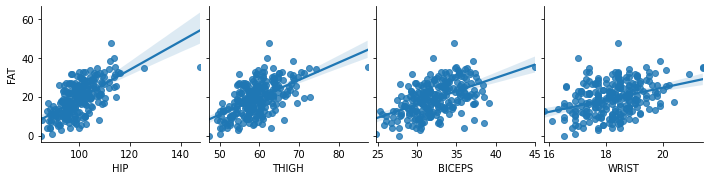

In [114]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["HIP", "THIGH", "BICEPS", "WRIST"], kind="reg", diag_kind = None)

## FAT과 다른 변수들의 산점도를 보았을 때 모두 유사한 모양을 형성하고 있어 구별이 어렵고 의미있는 결과를 도출하기 어렵다.

In [5]:
sns.pairplot(df_raw)

In [6]:
df_raw.corr().round(3)

FAT    AGE  WEIGHT  HEIGHT   NECK  CHEST  ABDOMEN    HIP  THIGH  \
FAT      1.000  0.291   0.612  -0.089  0.491  0.703    0.813  0.625  0.560   
AGE      0.291  1.000  -0.013  -0.172  0.114  0.176    0.230 -0.050 -0.200   
WEIGHT   0.612 -0.013   1.000   0.308  0.831  0.894    0.888  0.941  0.869   
HEIGHT  -0.089 -0.172   0.308   1.000  0.254  0.135    0.088  0.170  0.148   
NECK     0.491  0.114   0.831   0.254  1.000  0.785    0.754  0.735  0.696   
CHEST    0.703  0.176   0.894   0.135  0.785  1.000    0.916  0.829  0.730   
ABDOMEN  0.813  0.230   0.888   0.088  0.754  0.916    1.000  0.874  0.767   
HIP      0.625 -0.050   0.941   0.170  0.735  0.829    0.874  1.000  0.896   
THIGH    0.560 -0.200   0.869   0.148  0.696  0.730    0.767  0.896  1.000   
KNEE     0.509  0.018   0.853   0.286  0.672  0.719    0.737  0.823  0.799   
ANKLE    0.266 -0.105   0.614   0.265  0.478  0.483    0.453  0.558  0.540   
BICEPS   0.493 -0.041   0.800   0.208  0.731  0.728    0.685  0.739  0.761   
FOREARM  0.361 -0.085   0.630   0.229  0.624  0.580    0.503  0.545  0.567   
WRIST    0.347  0.214   0.730   0.322  0.745  0.660    0.620  0.630  0.559   

          KNEE  ANKLE  BICEPS  FOREARM  WRIST  
FAT      0.509  0.266   0.493    0.361  0.347  
AGE      0.018 -0.105  -0.041   -0.085  0.214  
WEIGHT   0.853  0.614   0.800    0.630  0.730  
HEIGHT   0.286  0.265   0.208    0.229  0.322  
NECK     0.672  0.478   0.731    0.624  0.745  
CHEST    0.719  0.483   0.728    0.580  0.660  
ABDOMEN  0.737  0.453   0.685    0.503  0.620  
HIP      0.823  0.558   0.739    0.545  0.630  
THIGH    0.799  0.540   0.761    0.567  0.559  
KNEE     1.000  0.612   0.679    0.556  0.665  
ANKLE    0.612  1.000   0.485    0.419  0.566  
BICEPS   0.679  0.485   1.000    0.678  0.632  
FOREARM  0.556  0.419   0.678    1.000  0.586  
WRIST    0.665  0.566   0.632    0.586  1.000

In [7]:
reg_model = smf.ols(formula= "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + \
KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Tue, 18 May 2021   Prob (F-statistic):           7.72e-64
Time:                        20:18:06   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

### 전체 분석 데이터의 개수는 252이고 자유도는 13이다.
### 252 - 13 - 1 = 238 이고 Df Residuals의 값이다.
### Omnibus는 잔차정규성을 나타내는 값으로 p-value = 0.111이므로 0.05보다 크다. 그러므로 정규성을 띈다는 사실을 알 수 있다.

In [8]:
df_raw_x = df_raw.drop("FAT", axis=1)

df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

variable       VIF
3    HEIGHT     1.675
10    ANKLE     1.908
12  FOREARM     2.192
1       AGE     2.250
13    WRIST     3.378
11   BICEPS     3.620
4      NECK     4.324
9      KNEE     4.612
8     THIGH     7.778
5     CHEST     9.461
6   ABDOMEN    11.767
7       HIP    14.797
2    WEIGHT    33.509
0     const  4091.886

In [9]:
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + \
KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_raw)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Tue, 18 May 2021   Prob (F-statistic):           7.72e-64
Time:                        20:18:06   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

In [10]:
df_raw_y = df_raw["FAT"]
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=5).fit(df_raw_x, df_raw_y)
selected_cols = df_raw_x.columns[rfe.support_]
removed_cols = df_raw_x.columns[~rfe.support_]

print("Selected Variables: {}".format(selected_cols))
print("Removed Variables: {}".format(removed_cols))

Selected Variables: Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables: Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


In [11]:
rfe_reg_model = smf.ols(formula="FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data=df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 18 May 2021   Prob (F-statistic):           4.38e-68
Time:                        20:18:06   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7037      6.231      0.434      0.6

In [12]:
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = False)

<AxesSubplot:>

<AxesSubplot:>

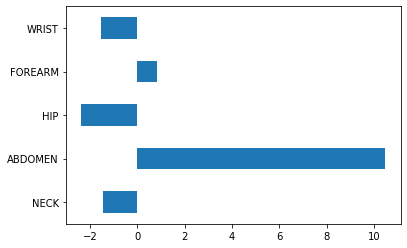

In [13]:
scaler = StandardScaler()
cols = df_raw_x.columns
np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns=cols)
df_scaled["FAT"]=df_raw["FAT"]
reg_model_scaled = smf.ols(formula="FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
df_reg_coef = pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y="Coef", legend=False)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

df_raw = pd.read_csv("3. Big Data 분석/DIABETES.csv", engine="python")

df_raw.head()

Y  AGE  GENDER   BMI     BP  CHOLESTEROL    LDL   HDL  TCH     LTG  \
0  151   59       2  32.1  101.0          157   93.2  38.0  4.0  4.8598   
1   75   48       1  21.6   87.0          183  103.2  70.0  3.0  3.8918   
2  141   72       2  30.5   93.0          156   93.6  41.0  4.0  4.6728   
3  206   24       1  25.3   84.0          198  131.4  40.0  5.0  4.8903   
4  135   50       1  23.0  101.0          192  125.4  52.0  4.0  4.2905   

   GLUCOSE  
0       87  
1       69  
2       85  
3       89  
4       80

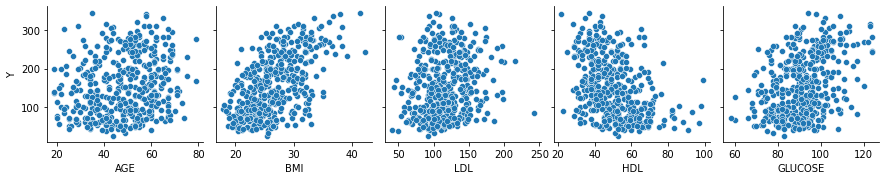

In [15]:
sns.pairplot(df_raw, y_vars="Y", x_vars=["AGE", "BMI", "LDL", "HDL", "GLUCOSE"], diag_kind = None)

In [16]:
df_raw.corr().round(3)

Y    AGE  GENDER    BMI     BP  CHOLESTEROL    LDL    HDL  \
Y            1.000  0.188   0.043  0.586  0.441        0.212  0.174 -0.395   
AGE          0.188  1.000   0.174  0.185  0.335        0.260  0.219 -0.075   
GENDER       0.043  0.174   1.000  0.088  0.241        0.035  0.143 -0.379   
BMI          0.586  0.185   0.088  1.000  0.395        0.250  0.261 -0.367   
BP           0.441  0.335   0.241  0.395  1.000        0.242  0.186 -0.179   
CHOLESTEROL  0.212  0.260   0.035  0.250  0.242        1.000  0.897  0.052   
LDL          0.174  0.219   0.143  0.261  0.186        0.897  1.000 -0.196   
HDL         -0.395 -0.075  -0.379 -0.367 -0.179        0.052 -0.196  1.000   
TCH          0.430  0.204   0.332  0.414  0.258        0.542  0.660 -0.738   
LTG          0.566  0.271   0.150  0.446  0.393        0.516  0.318 -0.399   
GLUCOSE      0.382  0.302   0.208  0.389  0.390        0.326  0.291 -0.274   

               TCH    LTG  GLUCOSE  
Y            0.430  0.566    0.382  
AGE          0.204  0.271    0.302  
GENDER       0.332  0.150    0.208  
BMI          0.414  0.446    0.389  
BP           0.258  0.393    0.390  
CHOLESTEROL  0.542  0.516    0.326  
LDL          0.660  0.318    0.291  
HDL         -0.738 -0.399   -0.274  
TCH          1.000  0.618    0.417  
LTG          0.618  1.000    0.465  
GLUCOSE      0.417  0.465    1.000

In [17]:
reg_model = smf.ols(formula= "Y ~ AGE + GENDER + BMI + BP + CHOLESTEROL + LDL + HDL + TCH + \
LTG", data = df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     51.29
Date:                Tue, 18 May 2021   Prob (F-statistic):           8.68e-63
Time:                        20:18:07   Log-Likelihood:                -2386.5
No. Observations:                 442   AIC:                             4793.
Df Residuals:                     432   BIC:                             4834.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -326.5741     67.006     -4.874      

In [18]:
df_raw_x = df_raw.drop("Y", axis=1)

df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

variable      VIF
1           AGE    1.217
2        GENDER    1.278
4            BP    1.459
10      GLUCOSE    1.485
3           BMI    1.509
8           TCH    8.891
9           LTG   10.076
7           HDL   15.402
6           LDL   39.193
5   CHOLESTEROL   59.203
0         const  685.774

In [19]:
reg_model = smf.ols(formula = "Y ~ AGE + GENDER + BMI + BP + CHOLESTEROL + LDL + HDL + TCH + \
LTG", data = df_raw)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     51.29
Date:                Tue, 18 May 2021   Prob (F-statistic):           8.68e-63
Time:                        20:18:07   Log-Likelihood:                -2386.5
No. Observations:                 442   AIC:                             4793.
Df Residuals:                     432   BIC:                             4834.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -326.5741     67.006     -4.874      

In [20]:
df_raw_y = df_raw["Y"]
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=4).fit(df_raw_x, df_raw_y)
selected_cols = df_raw_x.columns[rfe.support_]
removed_cols = df_raw_x.columns[~rfe.support_]

print("Selected Variables: {}".format(selected_cols))
print("Removed Variables: {}".format(removed_cols))

Selected Variables: Index(['GENDER', 'BMI', 'TCH', 'LTG'], dtype='object')
Removed Variables: Index(['AGE', 'BP', 'CHOLESTEROL', 'LDL', 'HDL', 'GLUCOSE'], dtype='object')


In [21]:
rfe_reg_model = smf.ols(formula="Y ~ AGE + BMI + LDL + HDL", data=df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     69.18
Date:                Tue, 18 May 2021   Prob (F-statistic):           2.42e-45
Time:                        20:18:07   Log-Likelihood:                -2438.8
No. Observations:                 442   AIC:                             4888.
Df Residuals:                     437   BIC:                             4908.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6270     27.815     -1.245      0.2

In [22]:
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = False)

<AxesSubplot:>

<AxesSubplot:>

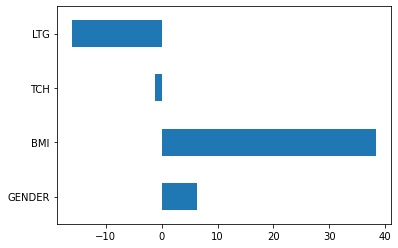

In [23]:
scaler = StandardScaler()
cols = df_raw_x.columns
np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns=cols)
df_scaled["Y"]=df_raw["Y"]
reg_model_scaled = smf.ols(formula="Y ~ AGE + BMI + LDL + HDL", data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
df_reg_coef = pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, index=selected_cols)
df_reg_coef.plot.barh(y="Coef", legend=False)

## 파생 변수 BMI가 FAT에 가장 많은 영향을 끼친다는 사실을 알 수 있다.

# 2. 의사결정나무

In [2]:
# 데이터 구성 : Series, DataFrame
import pandas as pd
# 데이터 시각화 
import matplotlib.pyplot as plt
import matplotlib
# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
#graphviz: 나무구조 시각화(.dot확장자 파일 불러오기 등)
import graphviz

In [3]:
df_raw = pd.read_csv("3. Big Data 분석/Concrete.csv",encoding= 'cp949')
df_raw.head()

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST  
0    45.0     29.0   21.4  
1    29.0     30.0   18.8  
2    30.8     25.7   18.8  
3    31.7     27.3   16.9  
4    34.7     29.1   18.4

In [140]:

df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength", axis =1, inplace =False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.4,random_state=1234)


In [141]:
df_raw

cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
0      540.0                 0.0      0.0  162.0               2.5   
1      540.0                 0.0      0.0  162.0               2.5   
2      332.5               142.5      0.0  228.0               0.0   
3      332.5               142.5      0.0  228.0               0.0   
4      198.6               132.4      0.0  192.0               0.0   
...      ...                 ...      ...    ...               ...   
1025   276.4               116.0     90.3  179.6               8.9   
1026   322.2                 0.0    115.6  196.0              10.4   
1027   148.5               139.4    108.6  192.7               6.1   
1028   159.1               186.7      0.0  175.6              11.3   
1029   260.9               100.5     78.3  200.6               8.6   

      coarse_aggregate  fine_aggregate  age  strength  
0               1040.0           676.0   28     79.99  
1               1055.0           676.0   28     61.89  
2                932.0           594.0  270     40.27  
3                932.0           594.0  365     41.05  
4                978.4           825.5  360     44.30  
...                ...             ...  ...       ...  
1025             870.1           768.3   28     44.28  
1026             817.9           813.4   28     31.18  
1027             892.4           780.0   28     23.70  
1028             989.6           788.9   28     32.77  
1029             864.5           761.5   28     32.40  

[1030 rows x 9 columns]

## 모델 생성

In [143]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))


Score on training set: 0.996
Score on test set: 0.790


In [145]:
tree_uncustomized

DecisionTreeRegressor(random_state=1234)

# 2.모델 파라미터 조정 

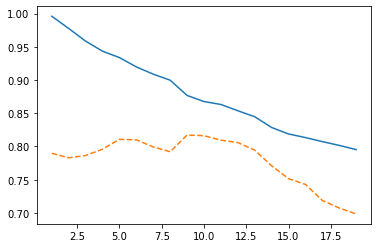

In [146]:
train_score =[]; test_score=[]
#min_samples_leaf: 입사귀 최소 자료수
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]
for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=1234,min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
#결과저장
df_score_leaf = pd.DataFrame()
plt.plot(para_leaf,train_score,linestyle="-", label = "Train Score")
plt.plot(para_leaf,test_score,linestyle="--", label = "Test Score")

df_score_leaf["MinSamplesLeaf"]= para_leaf
df_score_leaf["TrainScore"]= train_score
df_score_leaf["TestScore"]=test_score

## 모델 파라미터 조정 - min_samples_leaf: 입사귀 노드의 최소 자료수 변경

In [ ]:
#모델 설명력 확인  
df_score_leaf.round(3)
#모델 설명력 그래프 확인
plt.plot(para_leaf,train_score, linestyle="-",label = "Train Score")
plt.plot(para_leaf,test_score, linestyle="--",label = "Test Score")
plt.legend()

In [147]:
v_feature_name = df_train_x.columns
# 노드의 최소 자료수 =8모델
tree_graph = DecisionTreeRegressor(random_state =1234,min_samples_leaf =8)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file= "tree_leaf.dot",feature_names = v_feature_name, impurity = True,filled= True)

In [ ]:
# 입사귀 노드 최소 자료수 

In [148]:
import graphviz

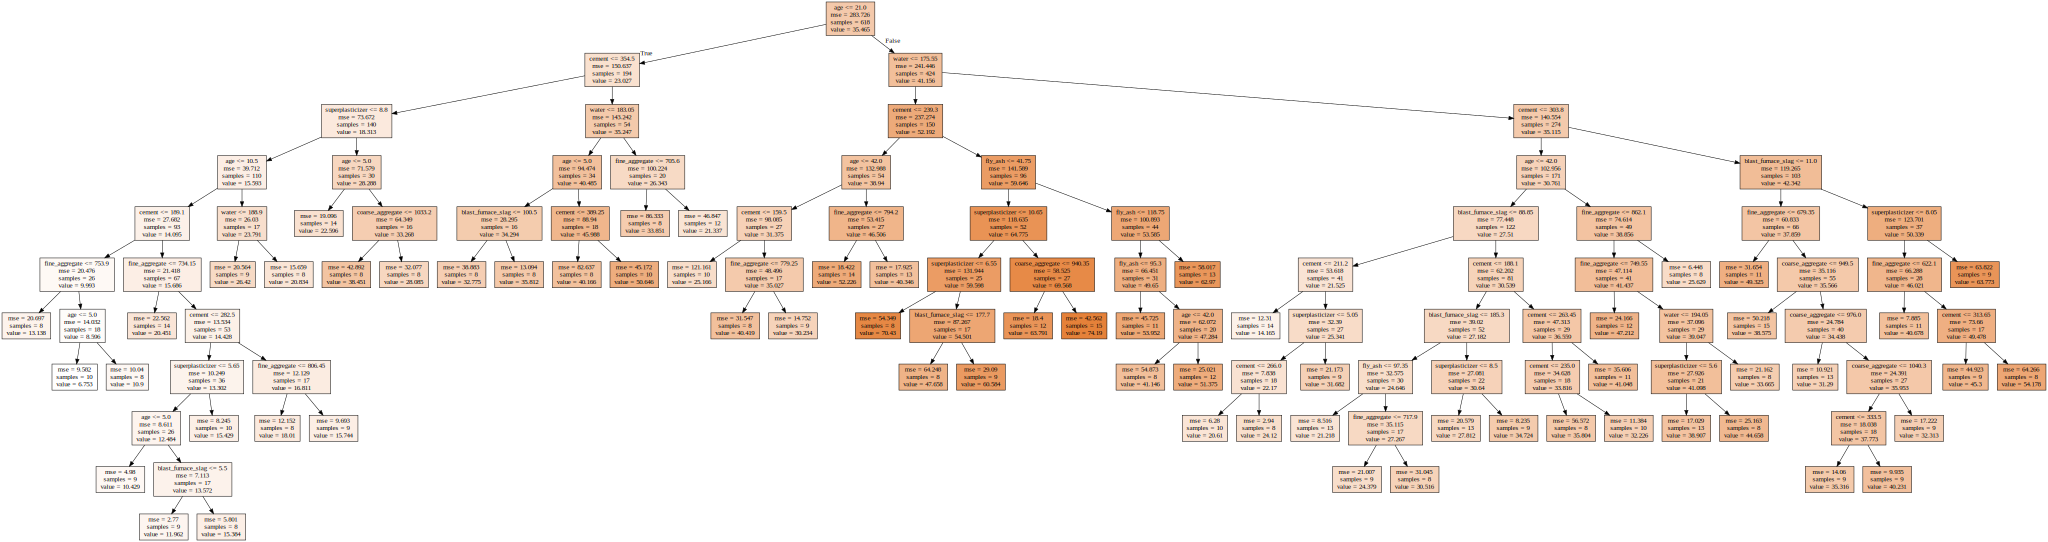

In [151]:
with open("tree_leaf.dot") as f:
    dot_graph= f.read()
display(graphviz.Source(dot_graph))

In [7]:
#train 및 test설명력 결과저장
train_score =[]; test_score=[]
#min_samples_split: 분리 노드의 최소자료수
para_split =[n_split *2 for n_split in range(2,20)]
for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=v_min_samples_split)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

NameError: name 'DecisionTreeRegressor' is not defined

In [5]:
#결과저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]= para_split
df_score_split["TrainScore"]= train_score
df_score_split["TestScore"]= test_score

NameError: name 'para_split' is not defined

In [6]:
plt.plot(para_leaf,train_score,linestyle="-", label = "Train Score")
plt.plot(para_leaf,test_score,linestyle="--", label = "Test Score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

NameError: name 'para_leaf' is not defined

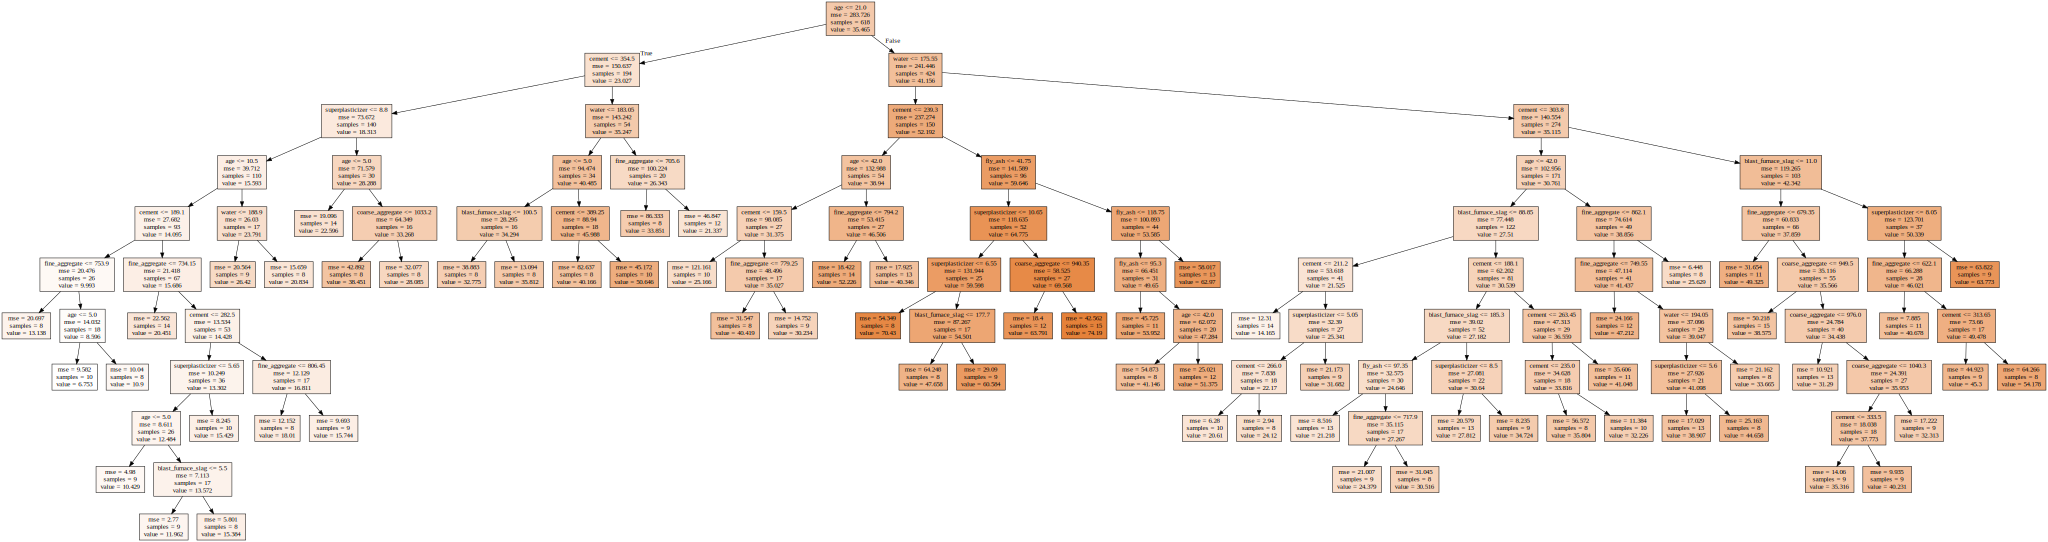

In [158]:
#변수명 저장
v_feature_name = df_train_x.columns
#노드의 최소 자료수 =8 모델
tree_graph = DecisionTreeRegressor(random_state =1234, min_samples_leaf =8)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file="tree_leaf.dot")
display(graphviz.Source(dot_graph))

## 모델 parameter조정 min_samples_split: 분리 노드의 최소 자료수 변경

In [159]:
#trin 및 test설명력 결과저장
train_score=[]; test_score=[]
#min_samples_split: 분리노드의 최소자료수 
para_split = [n_split *2 for n_split in range(2,20)]
for v_min_samples_split in para_split:
    tree =DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=v_min_samples_split)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
#결과저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]= para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score
df_score_split.round(3)

MinSamplesSplit  TrainScore  TestScore
0                 4       0.900      0.792
1                 6       0.900      0.792
2                 8       0.900      0.792
3                10       0.900      0.792
4                12       0.900      0.792
5                14       0.900      0.792
6                16       0.900      0.792
7                18       0.887      0.798
8                20       0.882      0.802
9                22       0.874      0.802
10               24       0.873      0.802
11               26       0.865      0.802
12               28       0.847      0.788
13               30       0.840      0.775
14               32       0.832      0.755
15               34       0.832      0.755
16               36       0.825      0.741
17               38       0.812      0.731

In [162]:
#모델 설명력 확인
df_score_split.round(3)

MinSamplesSplit  TrainScore  TestScore
0                 4       0.900      0.792
1                 6       0.900      0.792
2                 8       0.900      0.792
3                10       0.900      0.792
4                12       0.900      0.792
5                14       0.900      0.792
6                16       0.900      0.792
7                18       0.887      0.798
8                20       0.882      0.802
9                22       0.874      0.802
10               24       0.873      0.802
11               26       0.865      0.802
12               28       0.847      0.788
13               30       0.840      0.775
14               32       0.832      0.755
15               34       0.832      0.755
16               36       0.825      0.741
17               38       0.812      0.731

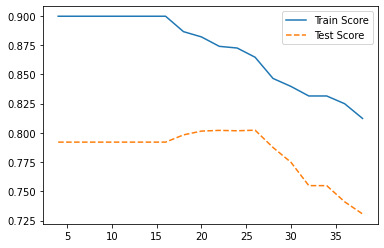

In [161]:
#모델 설명력 그래프 확인
plt.plot(para_split,train_score,linestyle="-",label ="Train Score")
plt.plot(para_split,test_score,linestyle="--",label= "Test Score")
plt.legend()

#### 그래프를 보면 구간 26부분이 가장 test score가 높고 train score와 test score의 차가 작은 것을 알 수있다.
#### 26에서 차는 0.063로 가장 높은 test score이기에 적절하다고 볼 수 있다. 

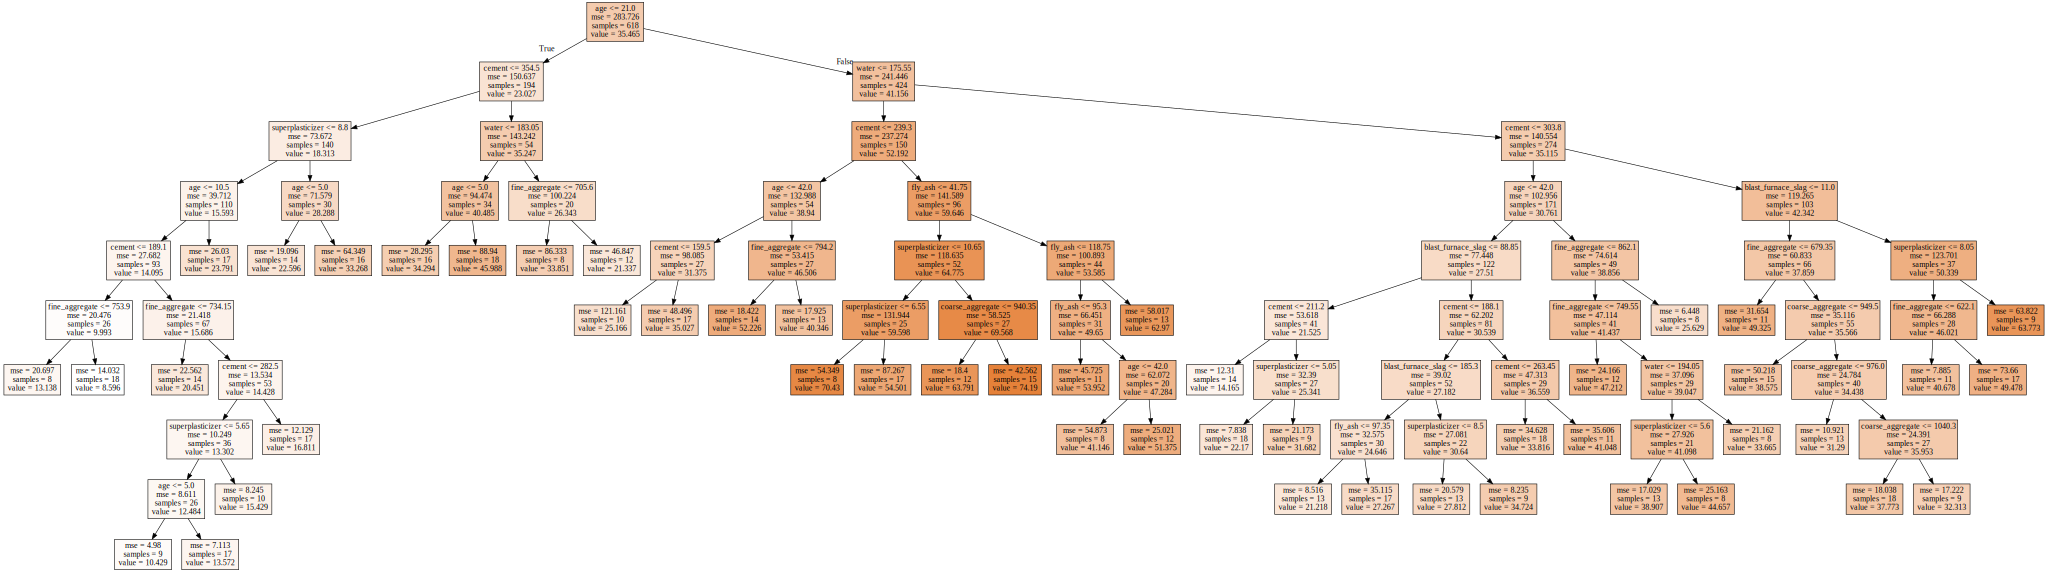

In [163]:
# 분리 노드의 최소 자료수 변경 결과 비교 (20 vs 26)
#분리노드의 최소 자료수 = 20 모델
tree_graph = DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=20)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file = "tree_split.dot",feature_names =v_feature_name,impurity=True,filled=True)
with open("tree_split.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


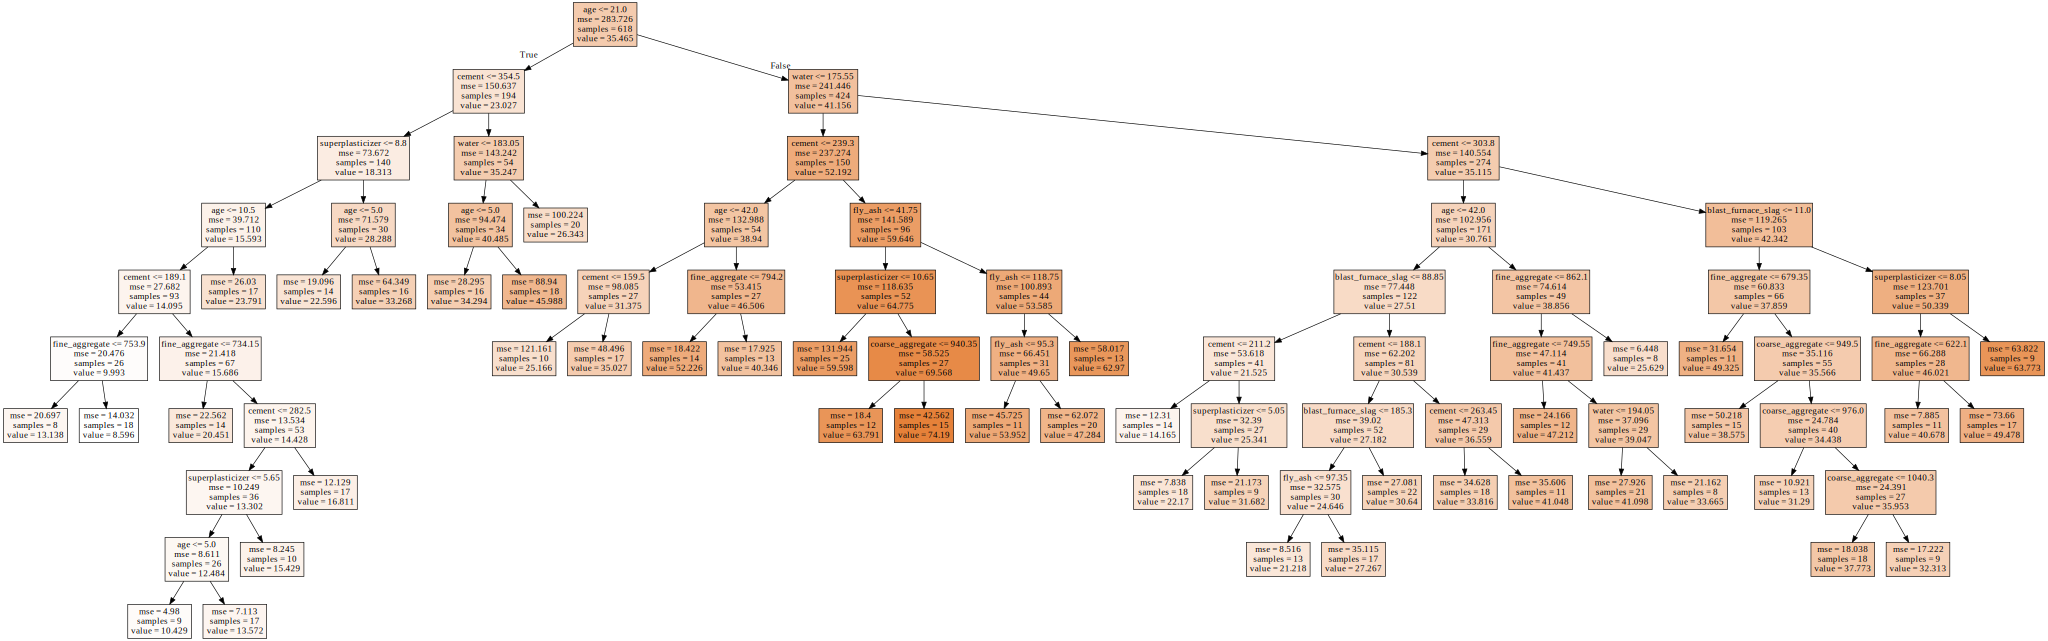

In [164]:
#분리 노드의 최소 자료수 =26모델
tree_graph = DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=26)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file = "tree_split.dot",feature_names =v_feature_name,impurity=True,filled=True)
with open("tree_split.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


In [167]:
# max_depth: 최대 깊이 변경에 따른 모델 성능
#train 및 test설명력 결과 저장
train_score =[]; test_score=[]
#max_depth: 최대 깊이 변경
para_depth =[depth for depth in range(1,11)]
for v_max_depth in para_depth:
    tree=DecisionTreeRegressor(random_state=1234,min_samples_leaf=8, min_samples_split=20,max_depth=v_max_depth)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_score_depth= pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score


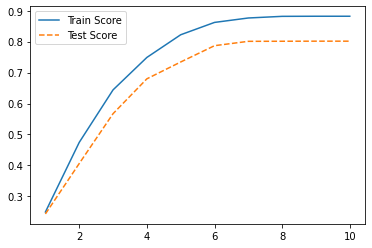

In [168]:
#모델 설명력 확인
df_score_split.round(3)
#모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle="-",label ="Train Score")
plt.plot(para_depth,test_score,linestyle="--",label= "Test Score")
plt.legend()

In [169]:
#max_depth: 최대 깊이 변경에 따른 모델 성능 
tree_graph= DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=20,max_depth=2)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file="tree_depth.dot",feature_names=v_feature_name,impurity=True, filled=True)
with open("tree_depth.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

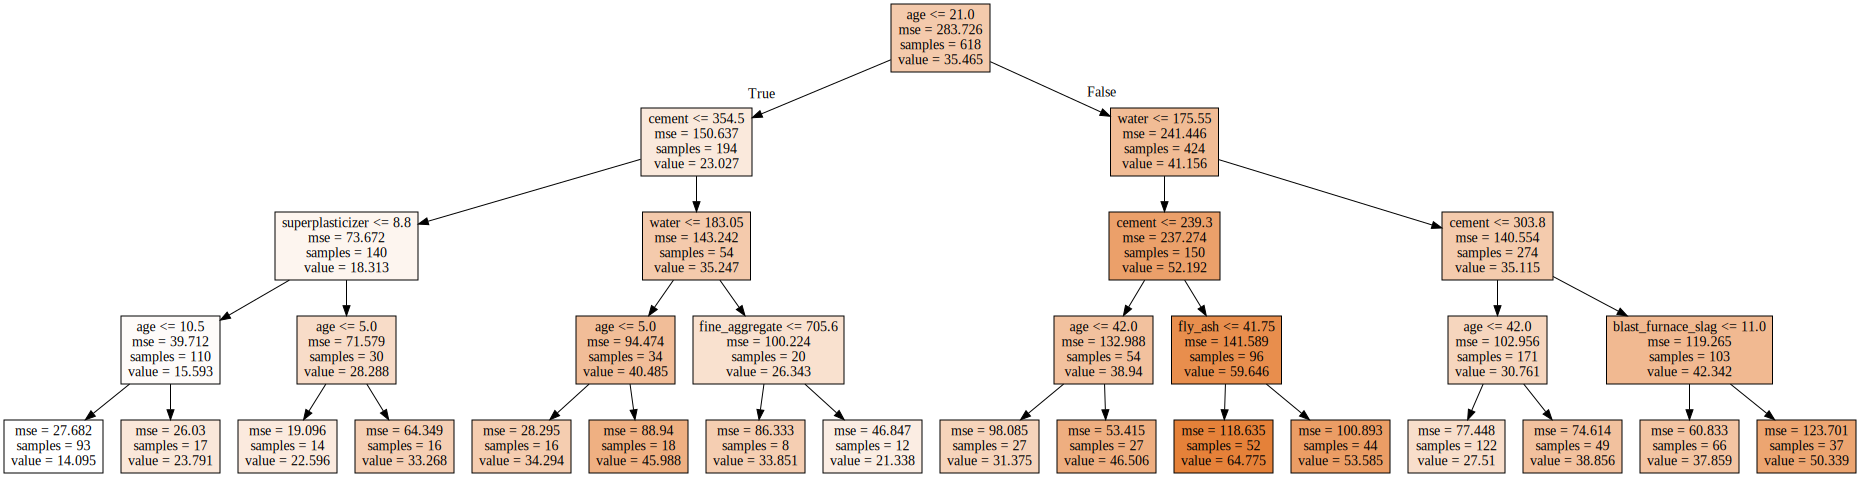

In [170]:
#max_depth: 최대 깊이 변경에 따른 모델 성능 
tree_graph= DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=20,max_depth=4)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file="tree_depth.dot",feature_names=v_feature_name,impurity=True, filled=True)
with open("tree_depth.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 3.최종 모델 선정

In [171]:
tree_final = DecisionTreeRegressor(criterion='mse',min_samples_leaf=8,min_samples_split=20,max_depth=4,random_state=1236)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=8, min_samples_split=20,
                      random_state=1236)

In [172]:
export_graphviz(tree_final,out_file="tree_final.dot",feature_names= v_feature_name,impurity=True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [173]:
tree_final = DecisionTreeRegressor(criterion='mae',min_samples_leaf=8,min_samples_split=20,max_depth=4,random_state=1236)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(criterion='mae', max_depth=4, min_samples_leaf=8,
                      min_samples_split=20, random_state=1236)

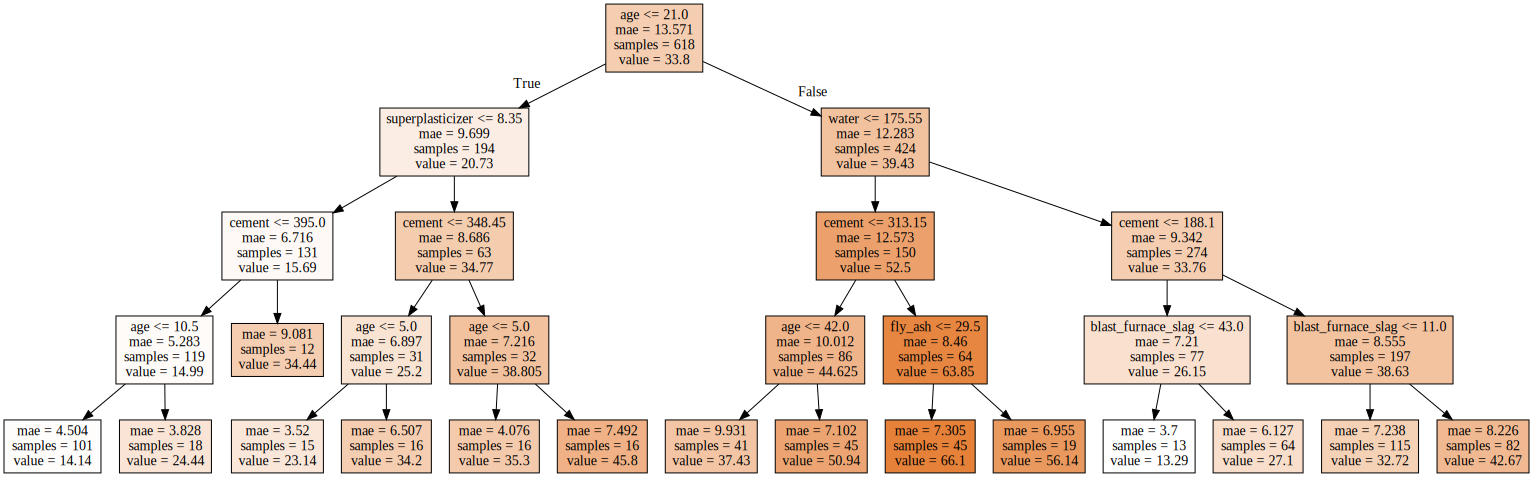

In [174]:
export_graphviz(tree_final,out_file="tree_final.dot",feature_names= v_feature_name,impurity=True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 결론 도출

In [175]:
# feature_importances_: 설명변수의 중요도

In [176]:
df_importance= pd.DataFrame()
df_importance["Feature"]= v_feature_name
df_importance["Importance"]= tree_final.feature_importances_
#df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)

Feature  Importance
7                 age       0.383
0              cement       0.245
3               water       0.178
4    superplasticizer       0.106
1  blast_furnace_slag       0.069
2             fly_ash       0.019
5    coarse_aggregate       0.000
6      fine_aggregate       0.000

### importance를 보면 값이 높을수록 Feature의 중요성이 높음을 의미한다.

Text(0, 0.5, '변수')

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/bac

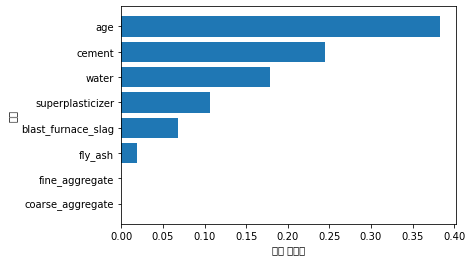

In [179]:
#설명변수 중요도 그래프
#중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance",ascending=True,inplace= True)
coordinates= range(len(df_importance))
plt.barh(y= coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
# randomforest => T => X변수 변경. 복원추출할때 칼럼이 다르다. 
# - X변수 바뀌면 조건이 다 바뀐다. - 다르게 해서 하는게 성능 더좋다. RANDOMFOREST가 일반적으로 성능이 더 좋다.
# 베깅이 더 성능은 좋다 / 트레인 데이터 로 개수는 똑같다. 중요도")
plt.ylabel("변수")


# 설명변수의 중요도 결과 
##### Depth가 너무 많으면 overfitting(과적합)이 발생하기 때문에 가장 큰 설명력을 가진 최소의 Depth에서 멈춘다. 

# 분류기준을 mse로 했을때와 mae로 했을때의 차이 


### MAE(Mean Absolute Error) : 모델의 예측값과 실제값의 차이를 모두 더한다는 개념 
#### 절대값을 취하기 때문에 가장 직관적으로 알 수 있는 지표
#### MSE보다 특이치에 Robust한다. - 이상치에 대한 저항도 가지고 있고, 데이터 특서을 잘 나타냄
#### 절대값을 취하기 때문에 모델이 underperformance인지 overperformance인지 알 수 없다. 
### MSE(Mean Squared Error) : 제곱을 하기 때문에 MAE와는 다르게 모델의 예측값과 실제값 차이 면적의 합이다. 특이치에 민감하다.
### 여기서는 MSE와 MAE는 별 차이가 없다.

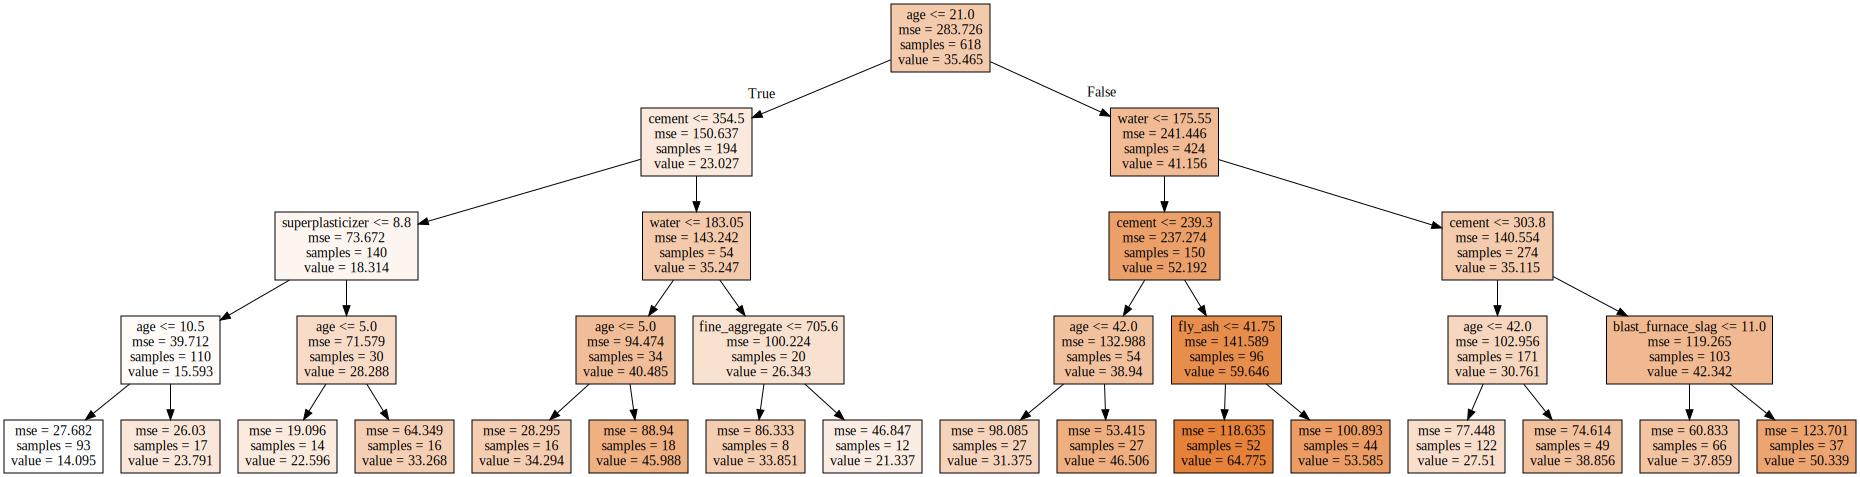

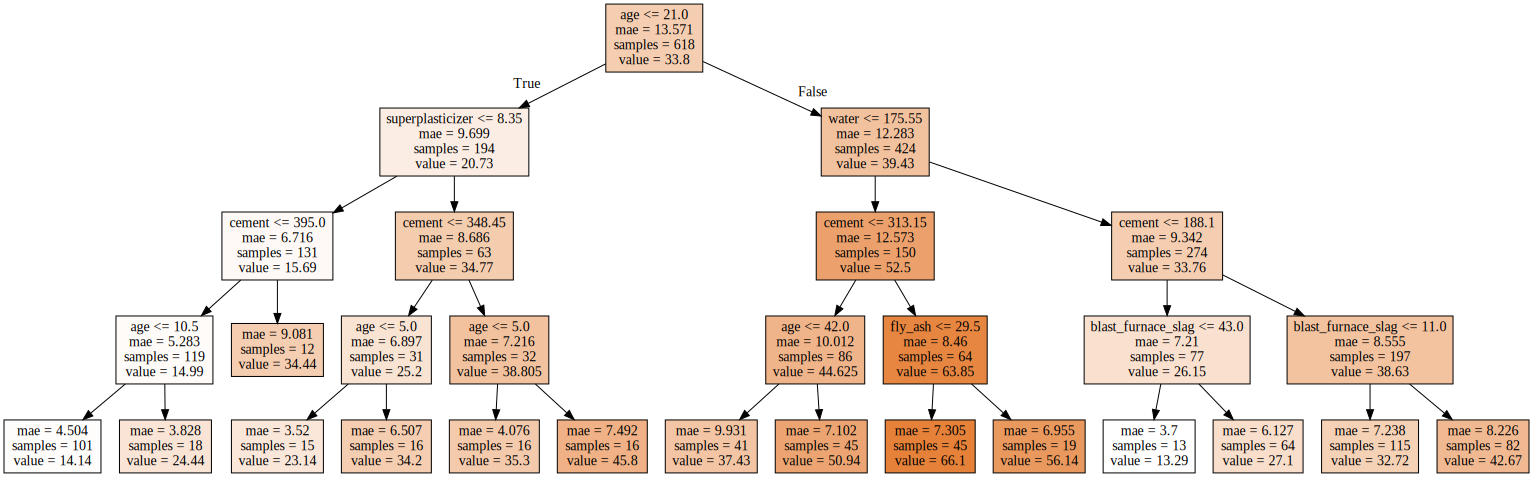

In [180]:
tree_final = DecisionTreeRegressor(criterion='mse',min_samples_leaf=8,min_samples_split=20,max_depth=4,random_state=1236)
tree_final.fit(df_train_x,df_train_y)



export_graphviz(tree_final,out_file="tree_final.dot",feature_names= v_feature_name,impurity=True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

tree_final = DecisionTreeRegressor(criterion='mae',min_samples_leaf=8,min_samples_split=20,max_depth=4,random_state=1236)
tree_final.fit(df_train_x,df_train_y)

export_graphviz(tree_final,out_file="tree_final.dot",feature_names= v_feature_name,impurity=True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 3. 랜덤 포레스트

## 데이터 구성하기

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

df_raw = pd.read_csv("3. Big Data 분석/Concrete.csv", engine="python")

df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength", axis = 1, inplace= False)

## 트레이닝 데이터와 테스트 데이터를 무작위로 나눈다.
## 테스트 데이터를 40% 트레이닝 데이터를 60%로 구성한다.

In [38]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.4, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


## 트레이닝 데이터는 618건, 테스트 데이터는 412건이 있다.

In [39]:
rf_uncustomized = RandomForestRegressor(random_state = 1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))
rf_uncustomized

Score on training set: 0.980
Score on test set: 0.904


RandomForestRegressor(random_state=1234)

## 모델 설명력은 트레이닝 데이터는 98.0%, 테스트 데이터는 90.4%이다.

## => 데이터를 무작위로 나누었는데 이 수치를 기록한다는 것이 굉장히 어려운 일이라고 생각한다.
## 그렇기 때문에 과적합이 일어난 것은 아닌지 의심해보아야 한다.

In [21]:
train_score = []
test_score = []
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators=v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

In [22]:
df_score_n.round(3)

n_estimators  TrainScore  TestScore
0            10       0.973      0.905
1            20       0.978      0.905
2            30       0.979      0.903
3            40       0.979      0.905
4            50       0.980      0.905
5            60       0.980      0.906
6            70       0.980      0.906
7            80       0.980      0.906
8            90       0.980      0.905
9           100       0.980      0.904

## n이 증가할수록 트레이닝 설명력과 테스트 설명력이 증가하지만 큰 증가는 일어나지 않는다.
## 최대 설명력 0.980과 0.096을 기록하는 n 중에서 가장 작은 60을 선택했다.

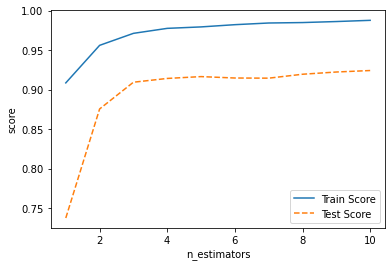

In [7]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

## 최소 잎사귀 노드 사이즈를 1씩 20까지 증가시켰을 때 트레이닝 데이터와 테스트 데이터 모두 설명력이 점점 감소한다.
## 가지치기
### 입사귀 노드의 최소 자료 수 지정

In [40]:
train_score = []
test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state = 1234, n_estimators = 100, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y)) 
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["n_estimators"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

n_estimators  TrainScore  TestScore
0              1       0.980      0.904
1              2       0.967      0.900
2              3       0.953      0.893
3              4       0.939      0.882
4              5       0.926      0.872
5              6       0.915      0.862
6              7       0.904      0.854
7              8       0.896      0.848
8              9       0.888      0.838
9             10       0.878      0.827
10            11       0.870      0.818
11            12       0.862      0.811
12            13       0.856      0.805
13            14       0.850      0.800
14            15       0.844      0.794
15            16       0.839      0.789
16            17       0.833      0.784
17            18       0.827      0.778
18            19       0.821      0.773
19            20       0.815      0.766

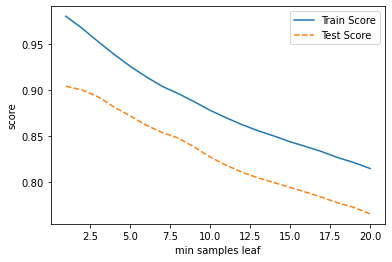

In [41]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

## 최소 split 노드의 사이즈를 4 ~ 40까지 짝수 값을 넣으면서 비교했을  때, 트레이닝 설명력이 0.990에서 점점 떨어지고 테스트 데이터 또한 마찬가지로 0.941에서 감소하는 것을 확인할 수 있다.

In [10]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state = 1234, n_estimators = 100,
                                min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

MinSamplesSplit  TrainScore  TestScore
0                 4       0.990      0.941
1                 6       0.987      0.938
2                 8       0.982      0.932
3                10       0.978      0.926
4                12       0.972      0.920
5                14       0.965      0.911
6                16       0.958      0.905
7                18       0.951      0.897
8                20       0.945      0.890
9                22       0.938      0.884
10               24       0.931      0.877
11               26       0.924      0.872
12               28       0.919      0.866
13               30       0.912      0.860
14               32       0.906      0.855
15               34       0.900      0.849
16               36       0.894      0.844
17               38       0.890      0.840

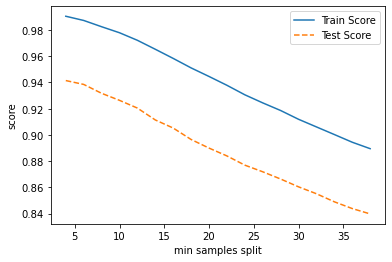

In [11]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

## 깊이를 1 ~ 30까지 넣으면서 트레이닝과 테스트 설명력을 비교한다.
## 최고 0.910, 0.858를 넘지 않는 것을 알 수 있다.

In [72]:
train_score = []
test_score = []
para_depth = [depth for depth in range(1, 31)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state = 1234,
                               min_samples_leaf = 6, min_samples_split = 4,
                               max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["MinSampleLeaf"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

MinSampleLeaf  TrainScore  TestScore
0               1       0.337      0.329
1               2       0.619      0.595
2               3       0.742      0.699
3               4       0.817      0.775
4               5       0.873      0.828
5               6       0.898      0.851
6               7       0.908      0.859
7               8       0.912      0.861
8               9       0.914      0.862
9              10       0.914      0.862
10             11       0.915      0.862
11             12       0.915      0.862
12             13       0.915      0.862
13             14       0.915      0.862
14             15       0.915      0.862
15             16       0.915      0.862
16             17       0.915      0.862
17             18       0.915      0.862
18             19       0.915      0.862
19             20       0.915      0.862
20             21       0.915      0.862
21             22       0.915      0.862
22             23       0.915      0.862
23             24       0.915      0.862
24             25       0.915      0.862
25             26       0.915      0.862
26             27       0.915      0.862
27             28       0.915      0.862
28             29       0.915      0.862
29             30       0.915      0.862

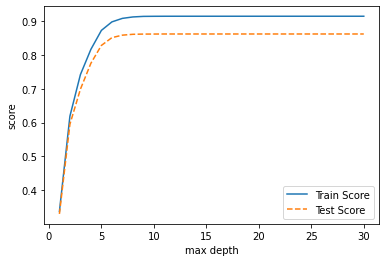

In [73]:
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

## 최대 트리 깊이를 9로 했을 때 트레이닝 set과 테스트 set 설명력 모두 최대를 기록하고
## 이후로는 계속 똑같은 설명력 수치를 가지기 때문에 9로 설정했다

## 최종적으로 트리의 개수는 35개, 최소 잎사귀는 1개, split 노드는 2개, 최대 깊이는 9로 설정했다.

In [86]:
rf_final = RandomForestRegressor(random_state=1234, n_estimators = 35, min_samples_leaf = 1,
                                min_samples_split = 2, max_depth = 9)
rf_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

rf_final

Score on training set: 0.971
Score on test set: 0.899


RandomForestRegressor(max_depth=9, n_estimators=35, random_state=1234)

# 최종 트레이닝 데이터 설명력은 97.1%
# 테스트 데이터 설명력은 89.9%이다.

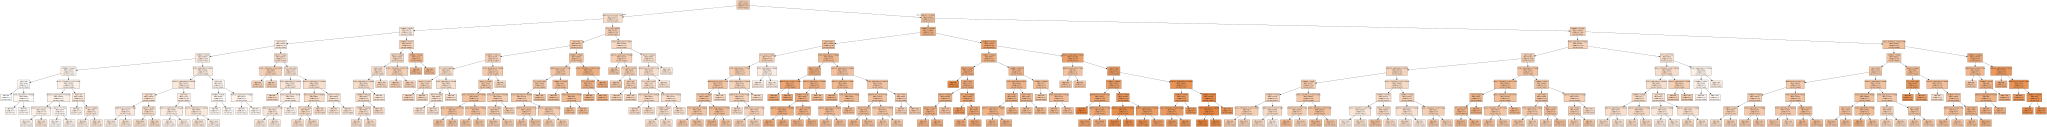

In [87]:
v_feature_name = df_train_x.columns
export_graphviz(rf_final.estimators_[0], out_file="rfr_final_0.dot", feature_names=v_feature_name, impurity= True, filled= True)
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

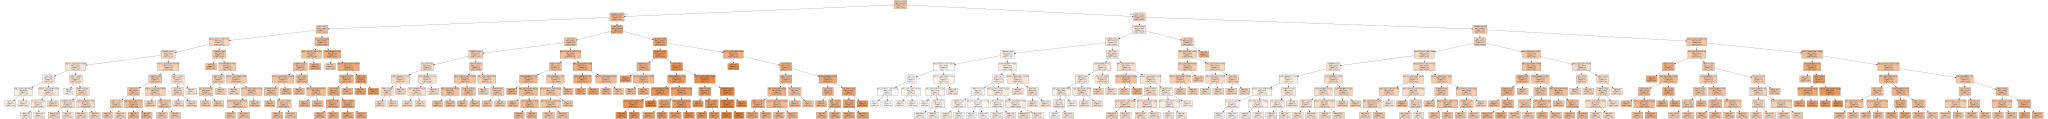

In [88]:
export_graphviz(rf_final.estimators_[1], out_file="rfr_final_1.dot", feature_names=v_feature_name, impurity= True, filled= True)
with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [89]:
export_graphviz(rf_final.estimators_[10], out_file="rfr_final_10.dot", feature_names=v_feature_name, impurity= True, filled= True)
with open("rfr_final_10.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [90]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

Feature  Importance
7                 age       0.349
0              cement       0.264
3               water       0.158
4    superplasticizer       0.078
1  blast_furnace_slag       0.051
6      fine_aggregate       0.044
5    coarse_aggregate       0.034
2             fly_ash       0.022

## 설명변수 중요도
### age 변수의 상대적 중요도가 가장 높음 

### 즉 콘크리트의 수명이 강도에 가장 많은 중요한 요소라는 것을 추정할 수 있다.

In [91]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

Text(0, 0.5, '변수')

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib

In [94]:
estimator = RandomForestRegressor(random_state=1234)
param_grid = {"max_depth": para_depth, "min_samples_split":para_split, "min_samples_leaf": para_leaf}
grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

KeyboardInterrupt: 

# 결론 : 